# Part x: Train Model with Debugger Hooks

<a id='aud-overview'> </a>

## [Overview](./0-AutoClaimFraudDetection.ipynb)
- [Part 3: Train Model with Debugger Hooks.](03_train_model_lineage_registry_debugger.ipynb)
    - [Fetch Data from Feature Store](#03-feature-store)
    - [Split Data and Save to S3](#03-split)
    - [Train Model](#03-train)
    - [SageMaker Debugger Reports](#03-debugger)

In this section we will show how you can assess pre-training and post-training bias with SageMaker Clarify, Train the Model using XGBoost on SageMaker, and then finally deposit it in the Model Registry, along with the Lineage of Artifacts that were created along the way: data, code and model metadata.

In this second model, you will fix the gender imbalance in the dataset using SMOTE and train another model using XGBoost. This model will also be saved to our registry and eventually approved for deployment.

<a id ='train'> </a>

## Architecture for the ML Lifecycle Stage: Train, Check Bias, Tune, Record Lineage, Register Model
[overview](#overview)
----

![train-assess-tune-register](./images/e2e-2-pipeline-v3b.png)

### Install required and/or update libraries

In [1]:
!pip install -qU smdebug
!pip install pandas --upgrade

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached pandas-1.3.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninsta

To apply the update to the current kernel, run the following code to refresh the kernel.

In [3]:
import sys
import pprint
import IPython
!{sys.executable} -m pip install -U sagemaker smdebug awswrangler
IPython.Application.instance().kernel.do_shutdown(True)

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 211 kB 43.2 MB/s            
     |████████████████████████████████| 43 kB 373 kB/s             
     |████████████████████████████████| 207 kB 79.9 MB/s            
  Using cached redshift_connector-2.0.889-py3-none-any.whl (94 kB)
  Using cached pytz-2021.3-py2.py3-none-any.whl (503 kB)
     |████████████████████████████████| 104 kB 83.6 MB/s            
  Attempting uninstall: asn1crypto
    Found existing installation: asn1crypto 1.3.0
    Uninstalling asn1crypto-1.3.0:
      Successfully uninstalled asn1crypto-1.3.0
  Attempting uninstall: p

{'status': 'ok', 'restart': True}

### Load stored variables
Run the cell below to load any prevously created variables. You should see a print-out of the existing variables. If you don't see anything you may need to create them again or it may be your first time running this notebook.

In [1]:
%store -r
%store

Stored variables and their in-db values:
bucket                              -> 'sagemaker-us-east-1-875692608981'
claims_fg_name                      -> 'fraud-detect-demo-claims'
claims_table                        -> 'fraud-detect-demo-claims-1635991472'
clarify_bias_job_1_name             -> 'Clarify-Bias-2021-11-04-02-57-18-432'
clarify_bias_job_2_name             -> 'Clarify-Bias-2021-11-04-03-30-25-420'
clarify_expl_job_name               -> 'Clarify-Explainability-2021-11-04-03-43-09-860'
col_order                           -> ['fraud', 'incident_type_breakin', 'num_vehicles_i
customers_fg_name                   -> 'fraud-detect-demo-customers'
customers_table                     -> 'fraud-detect-demo-customers-1635991475'
database_name                       -> 'sagemaker_featurestore'
endpoint_config_name                -> 'fraud-detect-demo-xgboost-post-smote-endpoint-con
endpoint_name                       -> 'fraud-detect-demo-xgboost-post-smote-endpoint'
hyperparameters   

**<font color='red'>Important</font>: You must have run the previous sequential notebooks to retrieve variables using the StoreMagic command.**

### Import libraries

In [2]:
import json
import time
import boto3
import sagemaker
import numpy as np
import pandas as pd
import awswrangler as wr

from sagemaker.xgboost.estimator import XGBoost
from model_package_src.inference_specification import InferenceSpecification

### Set region, boto3 and SageMaker SDK variables

In [3]:
# You can change this to a region of your choice
import sagemaker

region = sagemaker.Session().boto_region_name
print("Using AWS Region: {}".format(region))

Using AWS Region: us-east-1


In [4]:
boto3.setup_default_session(region_name=region)

boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")

sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)

sagemaker_role = sagemaker.get_execution_role()

account_id = boto3.client("sts").get_caller_identity()["Account"]

In [5]:
# variables used for parameterizing the notebook run
estimator_output_path = f"s3://{bucket}/{prefix}/training_jobs"
train_instance_count = 1
train_instance_type = "ml.m4.xlarge"
save_interval = 2
bias_report_1_output_path = f"s3://{bucket}/{prefix}/clarify-output/bias_1"


xgb_model_name = "xgb-insurance-claims-fraud-model"
train_instance_count = 1
train_instance_type = "ml.m4.xlarge"
predictor_instance_count = 1
predictor_instance_type = "ml.c5.xlarge"
batch_transform_instance_count = 1
batch_transform_instance_type = "ml.c5.xlarge"
claify_instance_count = 1
clairfy_instance_type = "ml.c5.xlarge"

In [6]:
# SHAP can take some time to install, so we will only install if it doesn't exist already
try:
    import shap
except ModuleNotFoundError:
    !conda install -y -c conda-forge shap

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.10.8          |   py37h89c1867_1         145 KB  conda-forge
    conda-4.10.3               |   py37h89c1867_3         3.1 MB  conda-forge
    shap-0.39.0                |   py37h51133e4_0         502 KB
    slicer-0.0.7               |     pyhd8ed1ab_0          16 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.7 MB

The following NEW packages will be INSTALLED:

  shap               pkgs/main/linux-64::shap-0.39.0-py37h51133e4_0
  slicer             conda-forge/noarch::slicer-0.0.7-pyhd8ed1ab_0

The following packages will be UPDATED:

  certifi                          2021.10.8-py37h89c1867_0 --> 2021.10.8-py37h89

<a id='aud-train-model'></a>

## Train a model using XGBoost

[overview](#overview)
----
Once the training and test datasets have been persisted in S3, you can start training a model by defining which SageMaker Estimator you'd like to use. For this guide, you will use the [XGBoost Open Source Framework](https://sagemaker.readthedocs.io/en/stable/frameworks/xgboost/xgboost.html) to train your model. This estimator is accessed via the SageMaker SDK, but mirrors the open source version of the [XGBoost Python package](https://xgboost.readthedocs.io/en/latest/python/index.html). Any functioanlity provided by the XGBoost Python package can be implemented in your training script.

In [7]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

### Set the hyperparameters
These are the parameters which will be sent to our training script in order to train the model. Although they are all defined as "hyperparameters" here, they can encompass XGBoost's [Learning Task Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters), [Tree Booster Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster), or any other parameters you'd like to configure for XGBoost.

In [8]:
hyperparameters = {
    "max_depth": "3",
    "eta": "0.2",
    "objective": "binary:logistic",
    "num_round": "100",
}
%store hyperparameters

Stored 'hyperparameters' (dict)


### Create and fit the estimator
If you want to explore the breadth of functionailty offered by the SageMaker XGBoost Framework you can read about all the configuration parameters by referencing the inhereting classes. The XGBoost class inherets from the Framework class and Framework inherets from the EstimatorBase class:
* [XGBoost Estimator documentation](https://sagemaker.readthedocs.io/en/stable/frameworks/xgboost/xgboost.html#sagemaker.xgboost.estimator.XGBoost)
* [Framework documentation](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Framework)
* [EstimatorBase documentation](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.EstimatorBase)

In [15]:
xgb_estimator = XGBoost(
    entry_point="xgboost_starter_script.py",
    output_path=estimator_output_path,
    code_location=estimator_output_path,
    hyperparameters=hyperparameters,
    role=sagemaker_role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    framework_version="1.2-1",
    
    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=estimator_output_path+'/debugger',  
        collection_configs=[
            CollectionConfig(name="metrics",parameters={"save_interval": str(save_interval)} ),
            CollectionConfig(name="feature_importance",parameters={"save_interval": str(save_interval)}),
            CollectionConfig(name="full_shap",parameters={"save_interval": str(save_interval)}),
            CollectionConfig(name="average_shap",parameters={"save_interval": str(save_interval)}),
        ],
    ),

    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        )
    ],
)

In [16]:
response = sagemaker_boto_client.list_training_jobs(
    NameContains = xgb_model_name,
    StatusEquals = 'Completed',
    SortBy='CreationTime',
    SortOrder='Descending'
)

In [17]:
%%time

train_model = True # True if training a new model, False if wanting to use an existing estimator once you've already trained

if train_model:
    print('Training the model')
    xgb_estimator.fit(inputs = {'train': train_data_uri,'validation': test_data_uri})
    s3_debugger_output_path = xgb_estimator.latest_job_debugger_artifacts_path()
    %store s3_debugger_output_path
elif len(response['TrainingJobSummaries']) > 0:
    training_job_3_name = response['TrainingJobSummaries'][0]['TrainingJobName']
    xgb_estimator = Estimator.attach(training_job_3_name)
    print(f'Using estimator from completed training job: {training_job_3_name}\nwith debugger path {s3_debugger_output_path}')
    %store training_job_3_name
else:
    print("No existing estimator found. You'll need to run as train = True")


Training the model
2021-11-05 00:19:07 Starting - Starting the training job...
2021-11-05 00:19:32 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
ProfilerReport-1636071547: InProgress
......
2021-11-05 00:20:32 Starting - Preparing the instances for training.........
2021-11-05 00:22:08 Downloading - Downloading input data...
2021-11-05 00:22:33 Training - Downloading the training image.....[2021-11-05 00:23:15.252 ip-10-2-164-166.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module xgboost_starter_script does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing mod

In [19]:
training_job_3_name = xgb_estimator.latest_training_job.job_name
%store training_job_3_name
print(training_job_3_name)
xgb_estimator.latest_training_job.rule_job_summary()

Stored 'training_job_3_name' (str)
sagemaker-xgboost-2021-11-05-00-19-07-235


[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:875692608981:processing-job/sagemaker-xgboost-2021-11--lossnotdecreasing-dacd6b29',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2021, 11, 5, 0, 26, 34, 584000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'ProfilerReport-1636071547',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:875692608981:processing-job/sagemaker-xgboost-2021-11--profilerreport-1636071547-7fc872bd',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2021, 11, 5, 0, 24, 27, 158000, tzinfo=tzlocal())}]

In [13]:
import pprint
training_job_info = sagemaker_boto_client.describe_training_job(TrainingJobName=training_job_3_name)
pprint.pprint(f"{training_job_info}")

("{'TrainingJobName': 'sagemaker-xgboost-2021-11-05-00-03-27-581', "
 "'TrainingJobArn': "
 "'arn:aws:sagemaker:us-east-1:875692608981:training-job/sagemaker-xgboost-2021-11-05-00-03-27-581', "
 "'ModelArtifacts': {'S3ModelArtifacts': "
 "'s3://sagemaker-us-east-1-875692608981/fraud-detect-demo/training_jobs/sagemaker-xgboost-2021-11-05-00-03-27-581/output/model.tar.gz'}, "
 "'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', "
 '\'HyperParameters\': {\'eta\': \'"0.2"\', \'max_depth\': \'"3"\', '
 '\'num_round\': \'"100"\', \'objective\': \'"binary:logistic"\', '
 "'sagemaker_container_log_level': '20', 'sagemaker_job_name': "
 '\'"sagemaker-xgboost-2021-11-05-00-03-27-581"\', \'sagemaker_program\': '
 '\'"xgboost_starter_script.py"\', \'sagemaker_region\': \'"us-east-1"\', '
 "'sagemaker_submit_directory': "
 '\'"s3://sagemaker-us-east-1-875692608981/fraud-detect-demo/training_jobs/sagemaker-xgboost-2021-11-05-00-03-27-581/source/sourcedir.tar.gz"\'}, '
 "'AlgorithmSpec

<a id='03-debugger'></a>

## View SageMaker Debugger Reports

##### [back to top](#03-nb)

----

### Create the Trail for the Experiment uisng the Debugger to generate trial debug-output

See this explanation for more information : https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md

In [14]:
%%time
from smdebug.trials import create_trial
s3_debugger_output_path
trial = create_trial(s3_debugger_output_path)


[2021-11-05 00:10:20.386 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:159 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-11-05 00:10:20.406 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:159 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-875692608981/fraud-detect-demo/training_jobs/debugger/sagemaker-xgboost-2021-11-05-00-03-27-581/debug-output


MissingCollectionFiles: Training job has ended. All the collection files could not be loaded

In [ ]:
feature_names = list(train.drop('fraud', axis=1).columns)
print(feature_names)


In [ ]:
from itertools import islice
import matplotlib.pyplot as plt
import re

MAX_PLOTS = 35

def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1]=="f{}".format(str(ifeat)): return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = (trial.collection(collection_name).tensor_names)
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

In [ ]:
plot_collection(trial, "metrics")

In [ ]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = [
        "weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(
            f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

In [ ]:
plot_feature_importance(trial, importance_type="gain")

### SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in the model output. You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculated by [xgboost.predict(pred_contribs=True)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.predict)) will be available the `average_shap` collection.
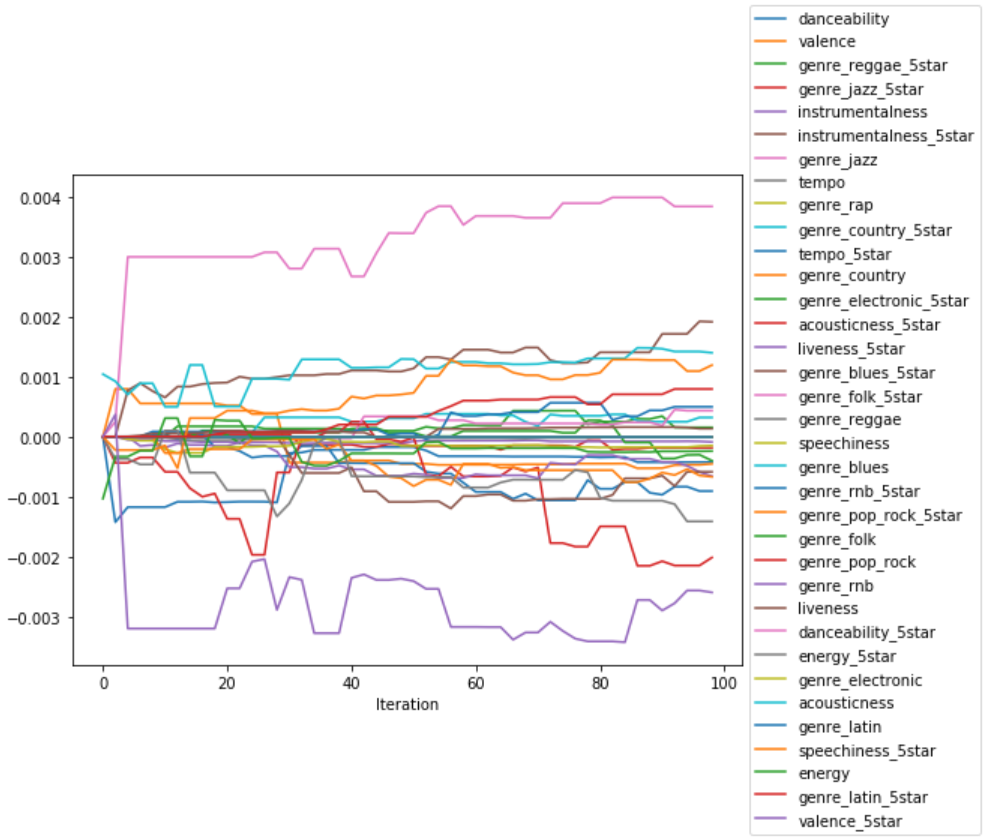

In [ ]:
plot_collection(trial, "average_shap")

### Global explanations

----

### Next Notebook: [Mitigate Bias, Train New Model, Store in Registry](./05-Mitigate-Bias-Train-Model2-Registry.ipynb)

To handle the imbalance, in the next notebook, we over-sample (i.e. upsample) the minority class using [SMOTE (Synthetic Minority Over-sampling Technique)](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html).

In [ ]:
ps.read('fraud-model')